# Data visualization, analysis, and prediction
Dataset from HR data ( https://www.kaggle.com/arashnic/hr-analytics-job-change-of-data-scientists )

In [61]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import warnings
warnings.filterwarnings("ignore")        
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.gridspec as grid_spec
import seaborn as sns
import squarify
from sklearn import preprocessing
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score


plt.rcParams["font.family"] = "serif"
plt.rcParams['figure.dpi'] = 200

In [50]:
# list data in da folder
import os
for dirname, _, filenames in os.walk('./data/'):
    for filename in filenames:
        print(os.path.join(dirname, filename)) 

./data/aug_test.csv
./data/aug_train.csv
./data/sample_submission.csv


In [51]:
train = pd.read_csv('./data/aug_train.csv')
test = pd.read_csv('./data/aug_test.csv')
train.head(10)

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1.0
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,11561,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0.0
3,33241,city_115,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52,1.0
4,666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0
5,21651,city_176,0.764,NaN,Has relevent experience,Part time course,Graduate,STEM,11,NaN,NaN,1,24,1.0
6,28806,city_160,0.920,Male,Has relevent experience,no_enrollment,High School,NaN,5,50-99,Funded Startup,1,24,0.0
7,402,city_46,0.762,Male,Has relevent experience,no_enrollment,Graduate,STEM,13,<10,Pvt Ltd,>4,18,1.0
8,27107,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,7,50-99,Pvt Ltd,1,46,1.0
9,699,city_103,0.920,NaN,Has relevent experience,no_enrollment,Graduate,STEM,17,10000+,Pvt Ltd,>4,123,0.0


## *Features:* 
- enrollee_id : Unique ID for candidate

- city: City code

- city_ development _index : Developement index of the city (scaled)

- gender: Gender of candidate

- relevent_experience: Relevant experience of candidate

- enrolled_university: Type of University course enrolled if any

- education_level: Education level of candidate

- major_discipline :Education major discipline of candidate

- experience: Candidate total experience in years

- company_size: No of employees in current employer's company

- company_type : Type of current employer

- lastnewjob: Difference in years between previous job and current job

- training_hours: training hours completed

- target: 0 – Not looking for job change, 1 – Looking for a job change

## Dealing with missing values


In [52]:
# Check for missing values
train.info()
train.isna().sum()/len(train)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19158 entries, 0 to 19157
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   enrollee_id             19158 non-null  int64  
 1   city                    19158 non-null  object 
 2   city_development_index  19158 non-null  float64
 3   gender                  14650 non-null  object 
 4   relevent_experience     19158 non-null  object 
 5   enrolled_university     18772 non-null  object 
 6   education_level         18698 non-null  object 
 7   major_discipline        16345 non-null  object 
 8   experience              19093 non-null  object 
 9   company_size            13220 non-null  object 
 10  company_type            13018 non-null  object 
 11  last_new_job            18735 non-null  object 
 12  training_hours          19158 non-null  int64  
 13  target                  19158 non-null  float64
dtypes: float64(2), int64(2), object(10)
me

enrollee_id               0.000000
city                      0.000000
city_development_index    0.000000
gender                    0.235306
relevent_experience       0.000000
enrolled_university       0.020148
education_level           0.024011
major_discipline          0.146832
experience                0.003393
company_size              0.309949
company_type              0.320493
last_new_job              0.022080
training_hours            0.000000
target                    0.000000
dtype: float64

**as we can see, most of the variables are categorical variables, and the dataset is not balanced.**

dealing with missing values can often be subjective. in this exercise, I'm going to impute missing data with forward fill

In [53]:
train["gender"] = train["gender"].fillna(method="pad")
train["enrolled_university"] = train["enrolled_university"].fillna(method="pad")
train["education_level"] = train["education_level"].fillna(method="pad")
train["education_level"] = train["education_level"].fillna(method="pad")
train["major_discipline"] = train["major_discipline"].fillna(method="pad")
train["experience"] = train["experience"].fillna(method="pad")
train["company_size"] = train["company_size"].fillna(method="pad")
train["company_type"] = train["company_type"].fillna(method="pad")
train["last_new_job"] = train["last_new_job"].fillna(method="pad")

## Data Visualization

In [71]:
# EDUCATION LEVEL
ed_order = ['Primary School','High School','Graduate','Masters','Phd']
train_graph_temp_df = pd.DataFrame(train["education_level"].value_counts())
train_graph_temp_df["Percentage"] = train_graph_temp_df["education_level"].apply(lambda x: x/sum(train_graph_temp_df["education_level"])*100).loc[ed_order]
train_graph_temp_df = train_graph_temp_df.sort_index()

test_graph_temp_df = pd.DataFrame(test["education_level"].value_counts())
test_graph_temp_df["Percentage"] = test_graph_temp_df["education_level"].apply(lambda x: x/sum(test_graph_temp_df["education_level"])*100).loc[ed_order]
test_graph_temp_df = test_graph_temp_df.sort_index()

test_graph_temp_df

,education_level,Percentage
Graduate,1269,61.097737
High School,222,10.688493
Masters,496,23.880597
Phd,54,2.599904
Primary School,36,1.733269


[Text(0, 0, 'Graduate'),
 Text(0, 0, 'High School'),
 Text(0, 0, 'Masters'),
 Text(0, 0, 'Phd'),
 Text(0, 0, 'Primary School')]

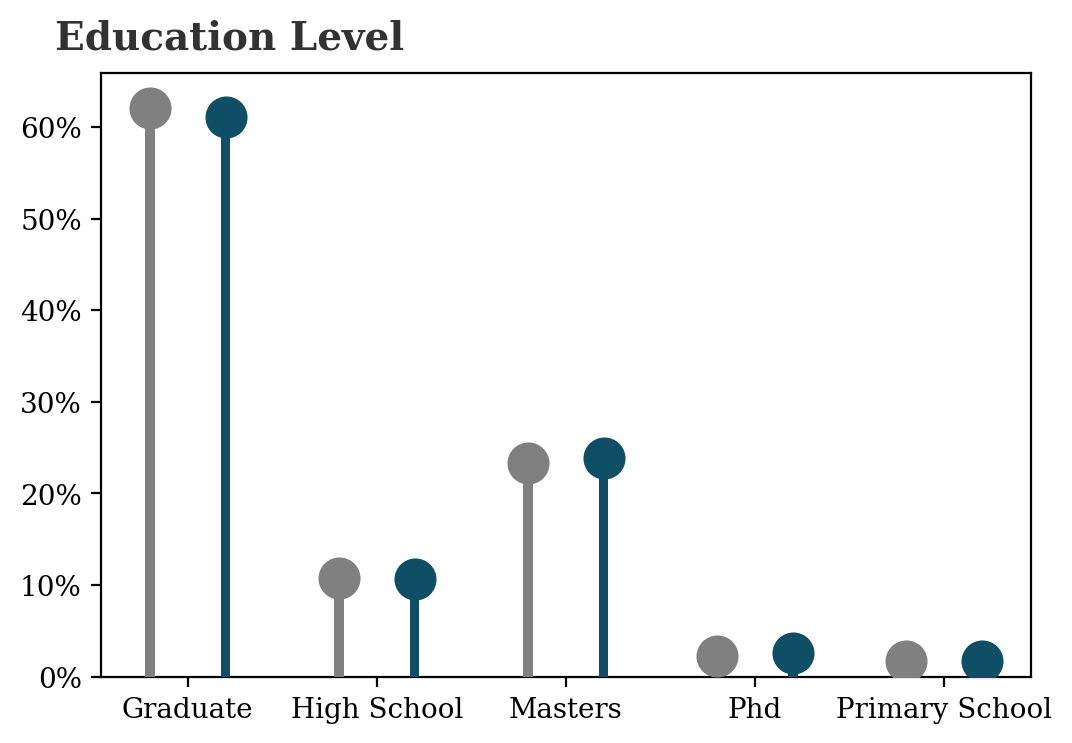

In [66]:
fig, ax = plt.subplots()
ax.bar(np.arange(len(train_graph_temp_df.index)), height=train_graph_temp_df["Percentage"], zorder=3, color="gray", width=0.05)
ax.scatter(np.arange(len(train_graph_temp_df.index)), train_graph_temp_df["Percentage"], zorder=3,s=200, color="gray")
ax.bar(np.arange(len(test_graph_temp_df.index))+0.4, height=test_graph_temp_df["Percentage"], zorder=3, color="#0e4f66", width=0.05)
ax.scatter(np.arange(len(test_graph_temp_df.index))+0.4, test_graph_temp_df["Percentage"], zorder=3,s=200, color="#0e4f66")
ax.text(-0.5, 68.5, 'Education Level', 
         fontsize=14, fontweight='bold', fontfamily='serif', color="#323232")
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.yaxis.set_major_locator(mtick.MultipleLocator(10))
ax.set_xticks(np.arange(len(train_graph_temp_df.index))+0.4 / 2)
ax.set_xticklabels(list(train_graph_temp_df.index),rotation=0)

In [146]:
# Ax1 - ENROLLED IN UNIVESITY
train_graph_temp_df = pd.DataFrame(train["enrolled_university"].value_counts())
train_graph_temp_df["Percentage"] = train_graph_temp_df["enrolled_university"].apply(lambda x: x/sum(train_graph_temp_df["enrolled_university"])*100)
train_graph_temp_df = train_graph_temp_df.sort_index()

test_graph_temp_df = pd.DataFrame(test["enrolled_university"].value_counts())
test_graph_temp_df["Percentage"] = test_graph_temp_df["enrolled_university"].apply(lambda x: x/sum(test_graph_temp_df["enrolled_university"])*100)
test_graph_temp_df = test_graph_temp_df.sort_index()

test_graph_temp_df

,enrolled_university,Percentage
Full time course,435,20.734032
Part time course,144,6.863680
no_enrollment,1519,72.402288


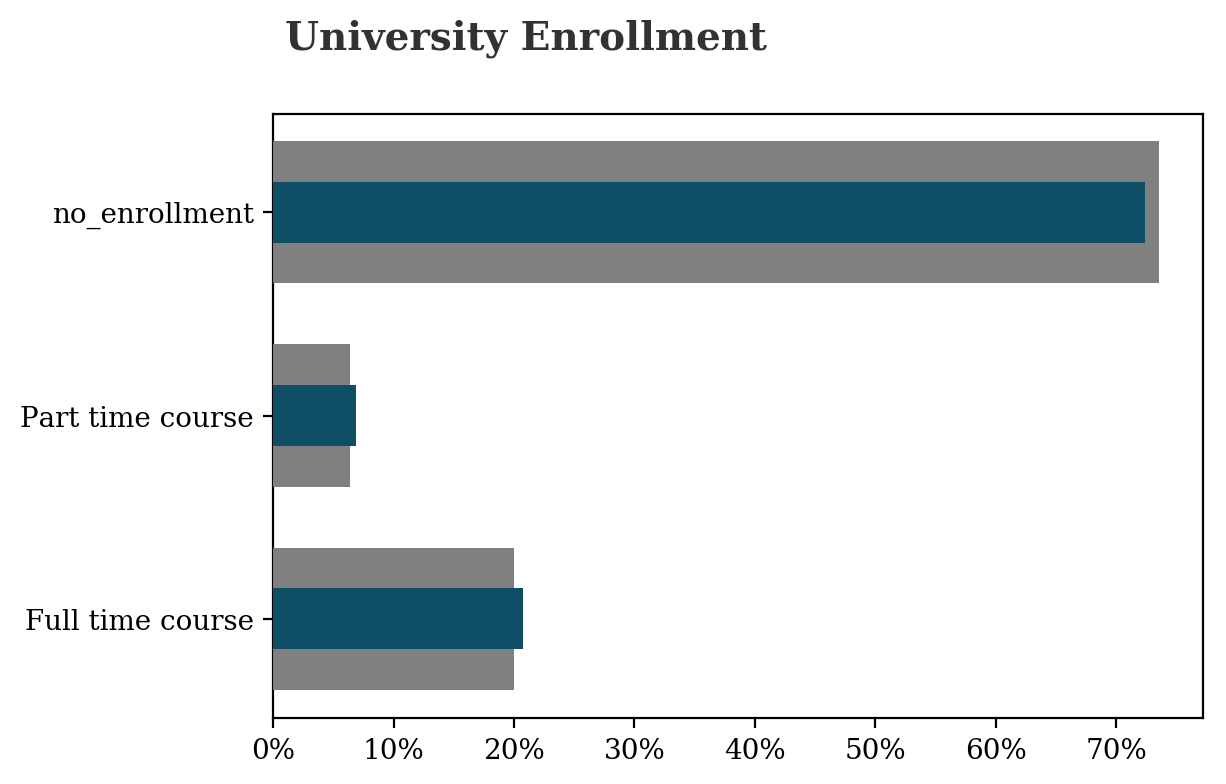

In [147]:
fig, ax = plt.subplots()
ax.text(1, 2.8, 'University Enrollment', fontsize=14, fontweight='bold', fontfamily='serif', color="#323232")
ax.barh(train_graph_temp_df.index, train_graph_temp_df['Percentage'], color="gray", zorder=3, height=0.7)
ax.barh(test_graph_temp_df.index, test_graph_temp_df['Percentage'], color="#0e4f66", zorder=3, height=0.3)
ax.xaxis.set_major_formatter(mtick.PercentFormatter())
ax.xaxis.set_major_locator(mtick.MultipleLocator(10))

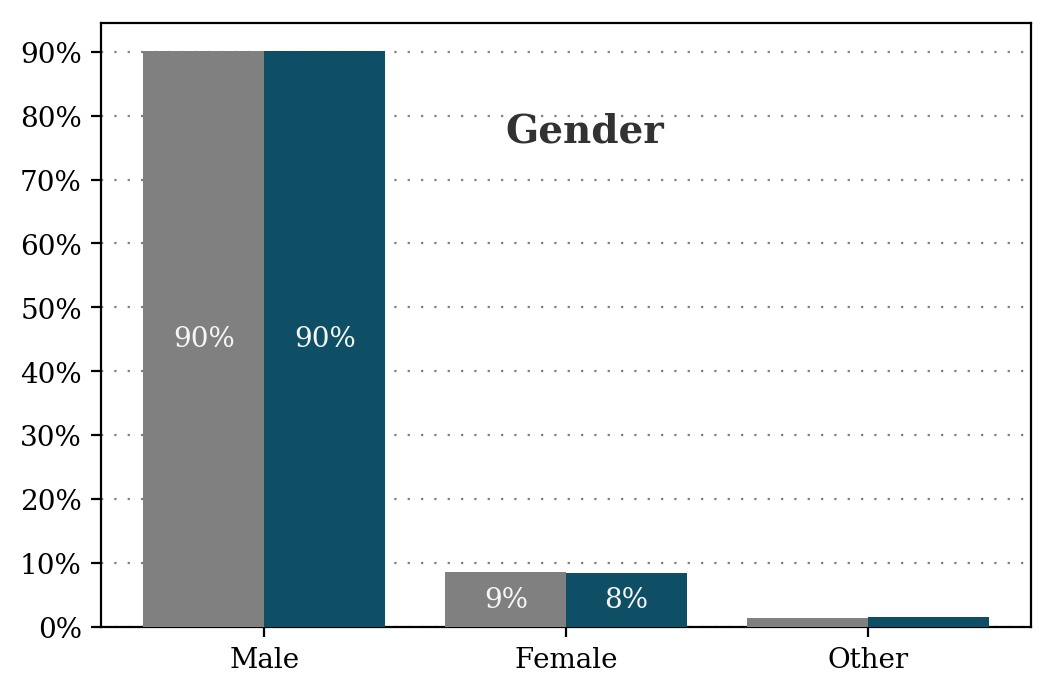

In [78]:
#GENDER 
train_graph_temp_df = pd.DataFrame(train["gender"].value_counts())
train_graph_temp_df["Percentage"] = train_graph_temp_df["gender"].apply(lambda x: x/sum(train_graph_temp_df["gender"])*100)
test_graph_temp_df = pd.DataFrame(test["gender"].value_counts())
test_graph_temp_df["Percentage"] = test_graph_temp_df["gender"].apply(lambda x: x/sum(test_graph_temp_df["gender"])*100)

x = np.arange(len(train_graph_temp_df))

fig, ax = plt.subplots()
ax.text(1, 76, 'Gender', fontsize=14, fontweight='bold', fontfamily='serif', color="#323232")
ax.grid(color='gray', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
ax.bar(x, height=train_graph_temp_df["Percentage"], zorder=3, color="gray", width=0.4)
ax.bar(x+0.4, height=test_graph_temp_df["Percentage"], zorder=3, color="#0e4f66", width=0.4)
ax.set_xticks(x + 0.4 / 2)
ax.set_xticklabels(['Male','Female','Other'])
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.yaxis.set_major_locator(mtick.MultipleLocator(10))
for i,j in zip([0, 1], train_graph_temp_df["Percentage"]):
    ax.annotate(f'{j:0.0f}%',xy=(i, j/2), color='#f6f6f6', horizontalalignment='center', verticalalignment='center')
for i,j in zip([0, 1], test_graph_temp_df["Percentage"]):
    ax.annotate(f'{j:0.0f}%',xy=(i+0.4, j/2), color='#f6f6f6', horizontalalignment='center', verticalalignment='center')
    
    

Text(0.5, 0, '')

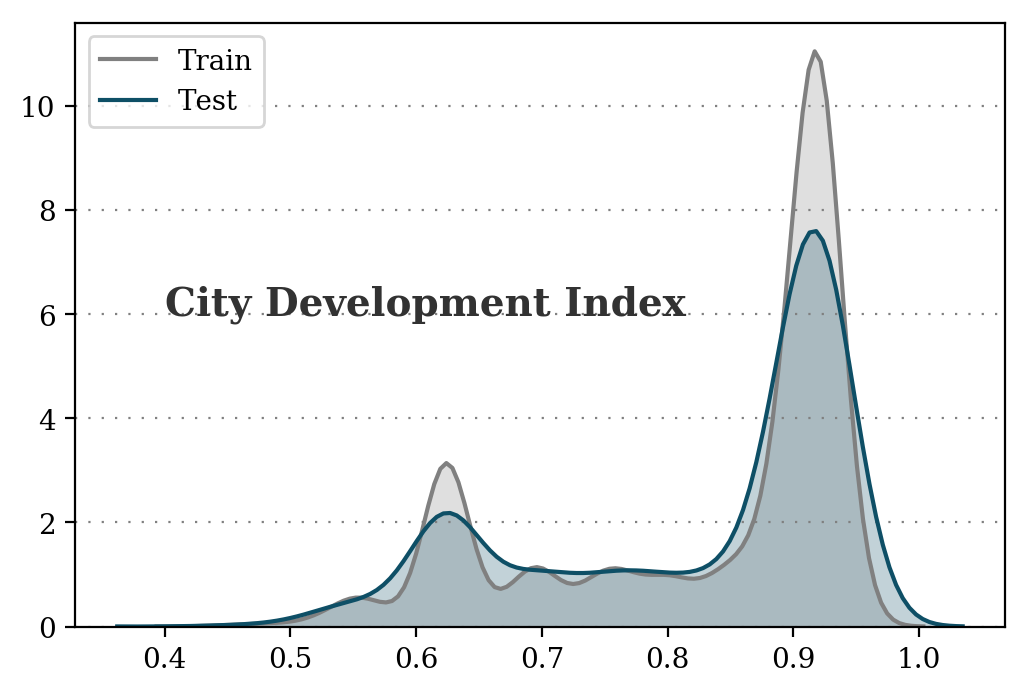

In [93]:
#CDI
train_graph_temp_df = pd.DataFrame(train["city_development_index"])
test_graph_temp_df = pd.DataFrame(test["city_development_index"])
fig, ax = plt.subplots()
ax.grid(color='gray', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.kdeplot(train_graph_temp_df["city_development_index"], ax=ax,color="gray", shade=True, label="Train")
sns.kdeplot(test_graph_temp_df["city_development_index"], ax=ax, color="#0e4f66", shade=True, label="Test")
ax.text(0.4, 6, 'City Development Index', 
         fontsize=14, fontweight='bold', fontfamily='serif', color="#323232")
ax.yaxis.set_major_locator(mtick.MultipleLocator(2))
ax.set_ylabel('')    
ax.set_xlabel('')

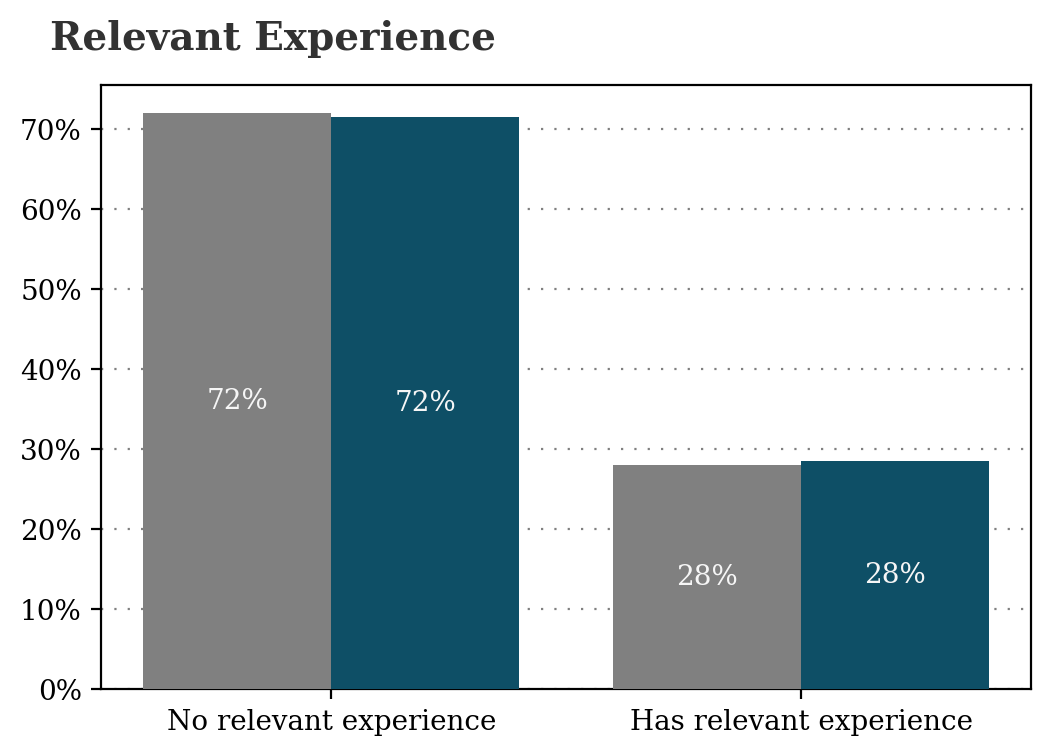

In [94]:
# EXPERIENCE
train_graph_temp_df = pd.DataFrame(train["relevent_experience"].value_counts())
train_graph_temp_df["Percentage"] = train_graph_temp_df["relevent_experience"].apply(lambda x: x/sum(train_graph_temp_df["relevent_experience"])*100)
test_graph_temp_df = pd.DataFrame(test["relevent_experience"].value_counts())
test_graph_temp_df["Percentage"] = test_graph_temp_df["relevent_experience"].apply(lambda x: x/sum(test_graph_temp_df["relevent_experience"])*100)

x = np.arange(len(train_graph_temp_df))
fig, ax = plt.subplots()
ax.text(-0.4, 80, 'Relevant Experience', fontsize=14, fontweight='bold', fontfamily='serif', color="#323232")
ax.grid(color='gray', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
ax.bar(x, height=train_graph_temp_df["Percentage"], zorder=3, color="gray", width=0.4)
ax.bar(x+0.4, height=test_graph_temp_df["Percentage"], zorder=3, color="#0e4f66", width=0.4)
ax.set_xticks(x + 0.4 / 2)
ax.set_xticklabels(['No relevant experience','Has relevant experience'])
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.yaxis.set_major_locator(mtick.MultipleLocator(10))

for i,j in zip([0, 1, 2], train_graph_temp_df["Percentage"]):
    ax.annotate(f'{j:0.0f}%',xy=(i, j/2), color='#f6f6f6', horizontalalignment='center', verticalalignment='center')
for i,j in zip([0, 1, 2], test_graph_temp_df["Percentage"]):
    ax.annotate(f'{j:0.0f}%',xy=(i+0.4, j/2), color='#f6f6f6', horizontalalignment='center', verticalalignment='center')

Text(0, 0.5, '')

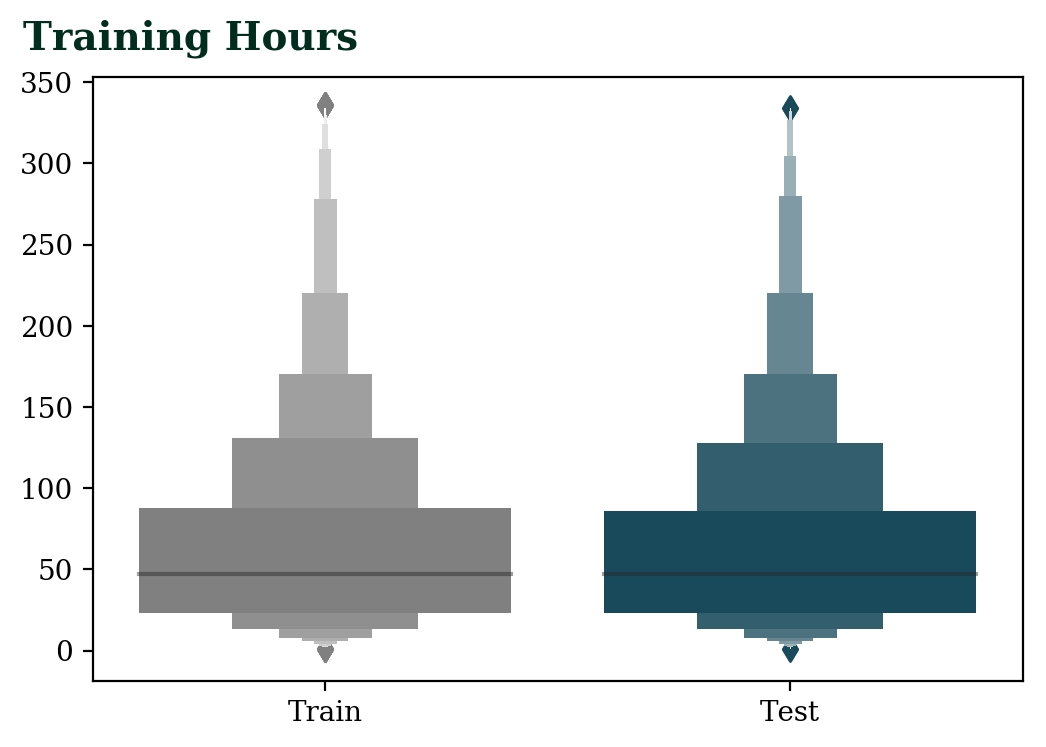

In [96]:
#TRAINING HOURS
train_graph_temp_df = pd.DataFrame(train["training_hours"])
train_graph_temp_df["TrainTest"] = "Train"
test_graph_temp_df = pd.DataFrame(test["training_hours"])
test_graph_temp_df["TrainTest"] = "Test"

fig, ax = plt.subplots()
ax.text(-0.65, 370, 'Training Hours', fontsize=14, fontweight='bold', fontfamily='serif', color="#002d1d")
comb_graph_temp_df = pd.concat([train_graph_temp_df, test_graph_temp_df], axis=0)
sns.boxenplot(ax=ax, y="training_hours", x="TrainTest", data=comb_graph_temp_df, palette=["gray", "#0e4f66"])
ax.set_xlabel("")
ax.set_ylabel("")

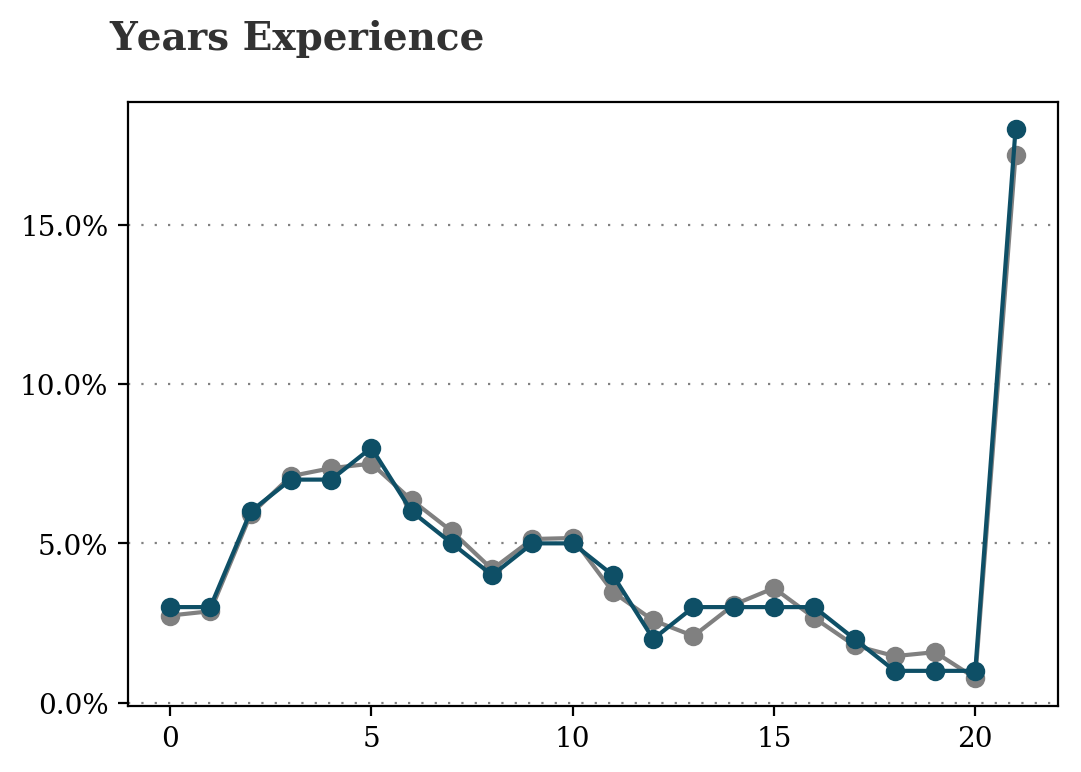

In [145]:
#EXPERIENCE YRS
train_graph_temp_df = pd.DataFrame(train["experience"].value_counts())
train_graph_temp_df["Percentage"] = train_graph_temp_df["experience"].apply(lambda x: x/sum(train_graph_temp_df["experience"])*100)
train_graph_temp_df['index1'] = train_graph_temp_df.index
train_graph_temp_df['index1'] = train_graph_temp_df['index1'].replace(['>20'],'21')
train_graph_temp_df['index1'] = train_graph_temp_df['index1'].replace(['<1'],'0')
train_graph_temp_df['index1']  = pd.to_numeric(train_graph_temp_df['index1'])
train_graph_temp_df = train_graph_temp_df.sort_values('index1')


test_graph_temp_df = pd.DataFrame(test["experience"].value_counts())
test_graph_temp_df["Percentage"] = round(test_graph_temp_df["experience"].apply(lambda x: x/sum(test_graph_temp_df["experience"])*100),).astype(int)

test_graph_temp_df['index1'] = test_graph_temp_df.index
test_graph_temp_df['index1'] = test_graph_temp_df['index1'].replace(['>20'],'21')
test_graph_temp_df['index1'] = test_graph_temp_df['index1'].replace(['<1'],'0')
test_graph_temp_df['index1']  = pd.to_numeric(test_graph_temp_df['index1'])
test_graph_temp_df = test_graph_temp_df.sort_values('index1')


fig, ax = plt.subplots()
ax.grid(color='gray', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
ax.plot(train_graph_temp_df['index1'], train_graph_temp_df["Percentage"], zorder=3, color="gray", marker='o')
ax.plot(test_graph_temp_df['index1'], test_graph_temp_df["Percentage"], zorder=3, color="#0e4f66", marker='o')
ax.text(-1.5, 20.5, 'Years Experience', 
         fontsize=14, fontweight='bold', fontfamily='serif', color="#323232")

#ax.set_yticklabels(labels = ['0   ', '5%','10%','15%',"20%"])
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.xaxis.set_major_locator(mtick.MultipleLocator(5))
ax.yaxis.set_major_locator(mtick.MultipleLocator(5))


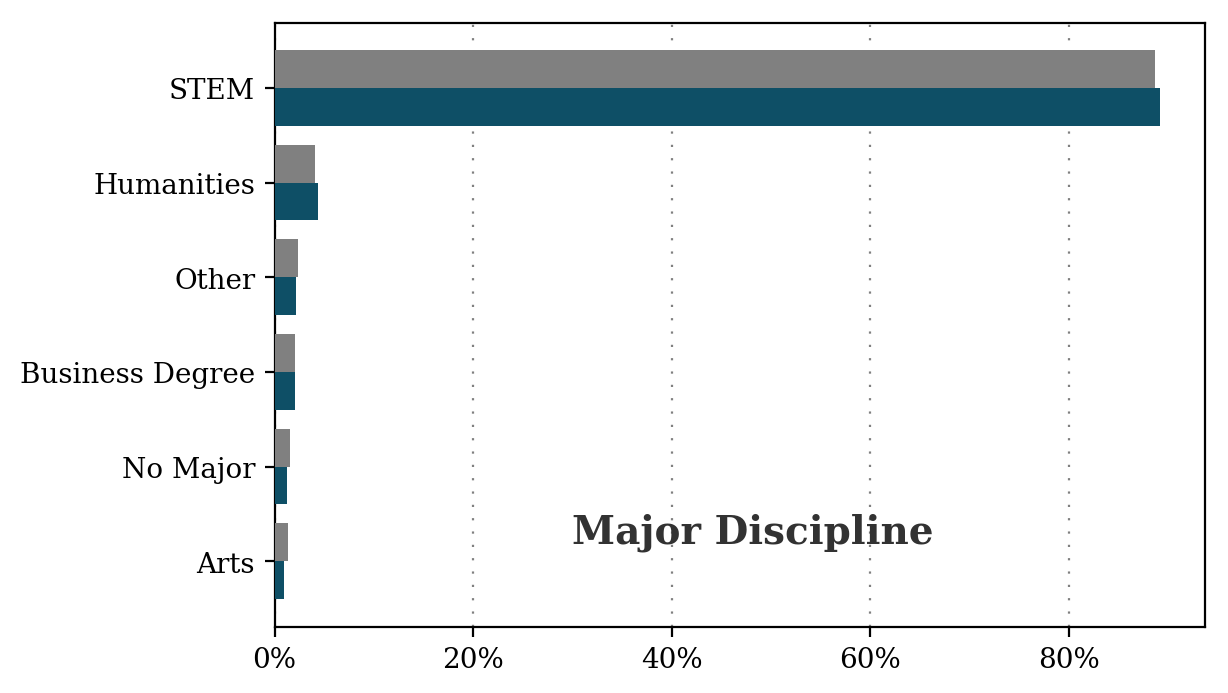

In [141]:
#MAJOR DISCIPLINE
train_graph_temp_df = pd.DataFrame(train["major_discipline"].value_counts())
train_graph_temp_df["Percentage"] = train_graph_temp_df["major_discipline"].apply(lambda x: x/sum(train_graph_temp_df["major_discipline"])*100)

test_graph_temp_df = pd.DataFrame(test["major_discipline"].value_counts())
test_graph_temp_df["Percentage"] = test_graph_temp_df["major_discipline"].apply(lambda x: x/sum(test_graph_temp_df["major_discipline"])*100)

fig, ax = plt.subplots()
ax.grid(color='gray', linestyle=':', axis='x', zorder=0,  dashes=(1,5))
ax.barh(np.arange(len(train_graph_temp_df.index)), train_graph_temp_df["Percentage"], zorder=3, color="gray", height=0.4)
ax.barh(np.arange(len(test_graph_temp_df.index))+0.4, test_graph_temp_df["Percentage"], zorder=3, color="#0e4f66", height=0.4)
ax.text(30, 5, 'Major Discipline', 
         fontsize=14, fontweight='bold', fontfamily='serif', color="#323232")
ax.xaxis.set_major_formatter(mtick.PercentFormatter())
ax.yaxis.set_major_locator(mtick.MultipleLocator(1))
ax.set_yticks(np.arange(len(test_graph_temp_df.index))+0.4 / 2)
ax.set_yticklabels(list(test_graph_temp_df.index))
ax.invert_yaxis()



## Findings:

- training set and testing set are pretty similar which is good
- 90% people in this sample are male
- 88% are STEM majored
- 60% of them have greduate degree, 30% has master degree
- more than 30% of them has 10+ yrs experiences

## let's focus on the features in training set
a couple points to look into:
1. who is looking for a new job, by gender
2. in which cities are the job seekers living
3. what similarities do they have

Text(0, 0.5, '')

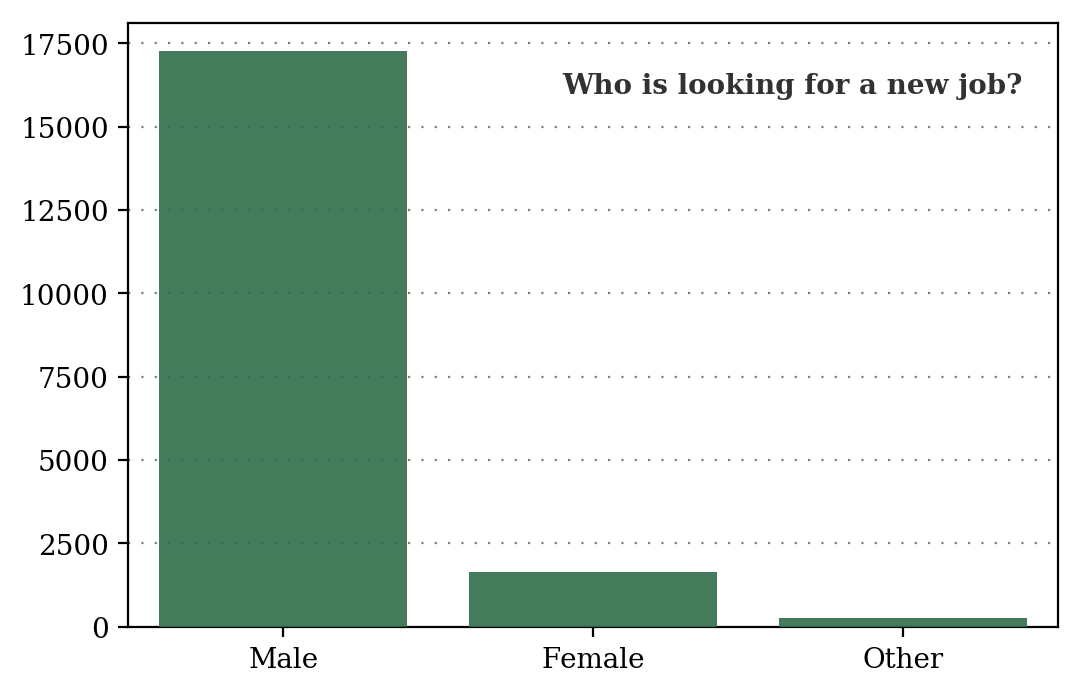

In [181]:
# Distribution
color_palette=["gray","#0e4f66"]

fig, ax = plt.subplots()
ax.text(0.9, 16000, 'Who is looking for a new job?', fontsize=10, fontweight='bold', fontfamily='serif', color="#323232")
ax.grid(color='gray', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.countplot(x=train["gender"], color="#247747", ax=ax, zorder=3,alpha=0.9)
ax.set_xlabel("")
ax.set_ylabel("")

Text(0, 0.5, '')

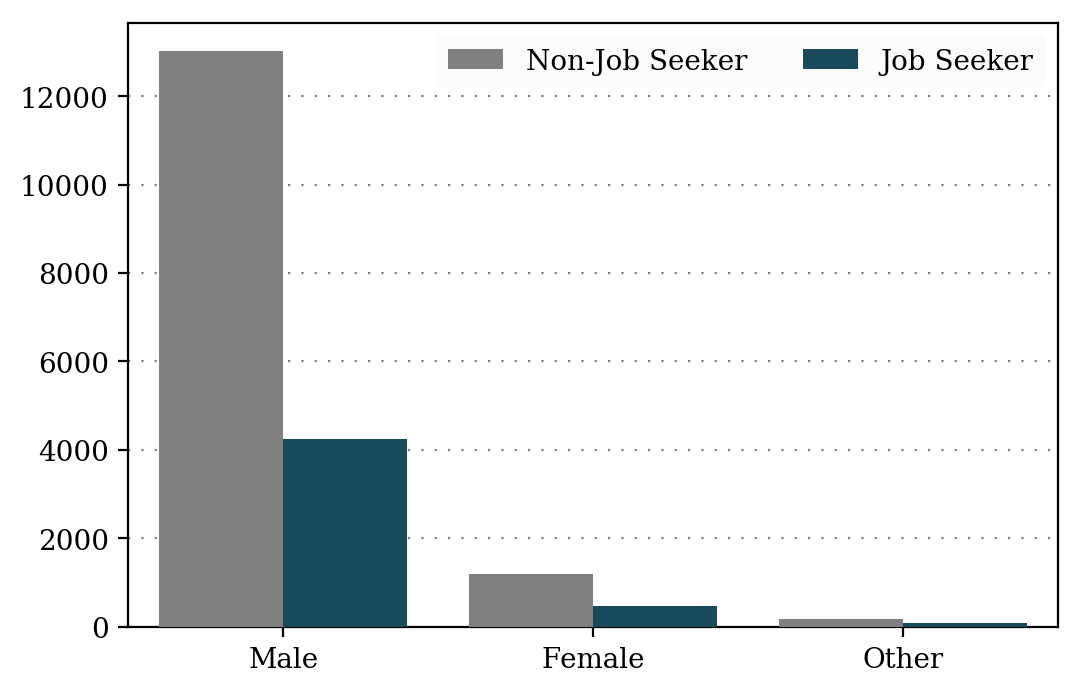

In [187]:
#by gender
fig, ax = plt.subplots()
#ax.text(-1, 11000, 'Job searching by gender', fontsize=14, fontweight='bold', fontfamily='serif', color="#323232")
ax.grid(color='gray', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.countplot(x="gender", hue="target", data=train, palette=color_palette, ax=ax, zorder=3)
legend_labels, _= ax.get_legend_handles_labels()
ax.legend(legend_labels, ["Non-Job Seeker", "Job Seeker"], ncol=2, bbox_to_anchor=(1, 1), 
           facecolor='#fbfbfb', edgecolor='#fbfbfb')
ax.set_xlabel("")
ax.set_ylabel("")

Text(0, 0.5, '')

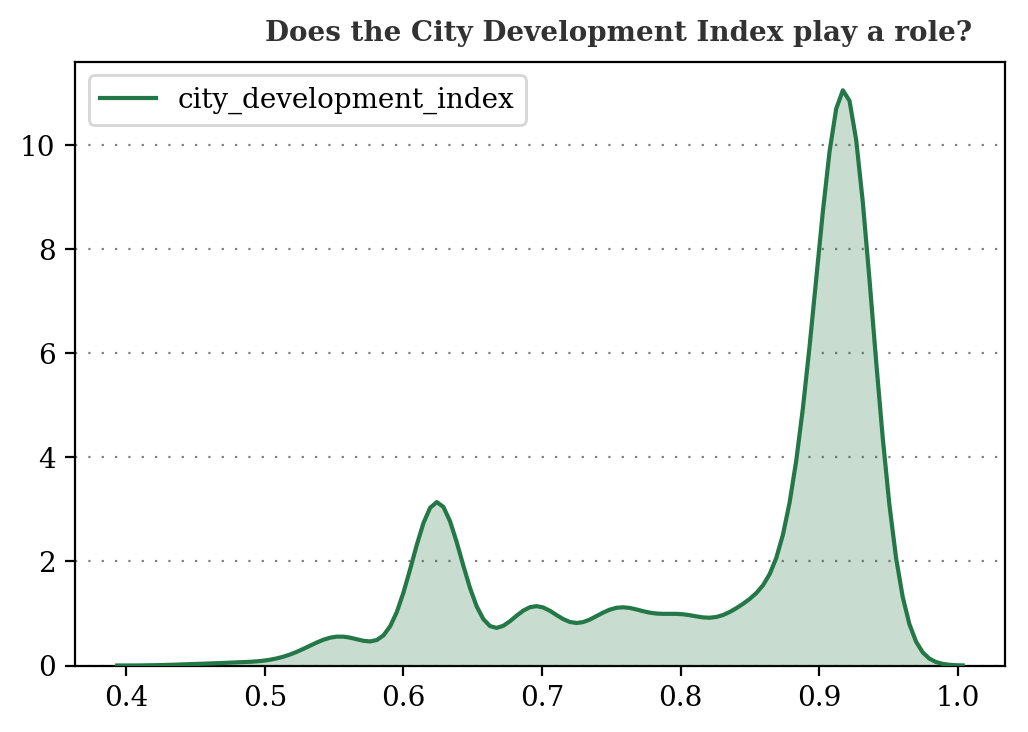

In [197]:
# CDI
fig, ax = plt.subplots()
ax.text(0.5, 12, 'Does the City Development Index play a role?', fontsize=10, fontweight='bold', fontfamily='serif', color="#323232")

ax.grid(color='gray', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.kdeplot(train["city_development_index"], color="#247747", shade=True, ax=ax, zorder=3)
ax.set_xlabel("")
ax.set_ylabel("")


Text(0, 0.5, '')

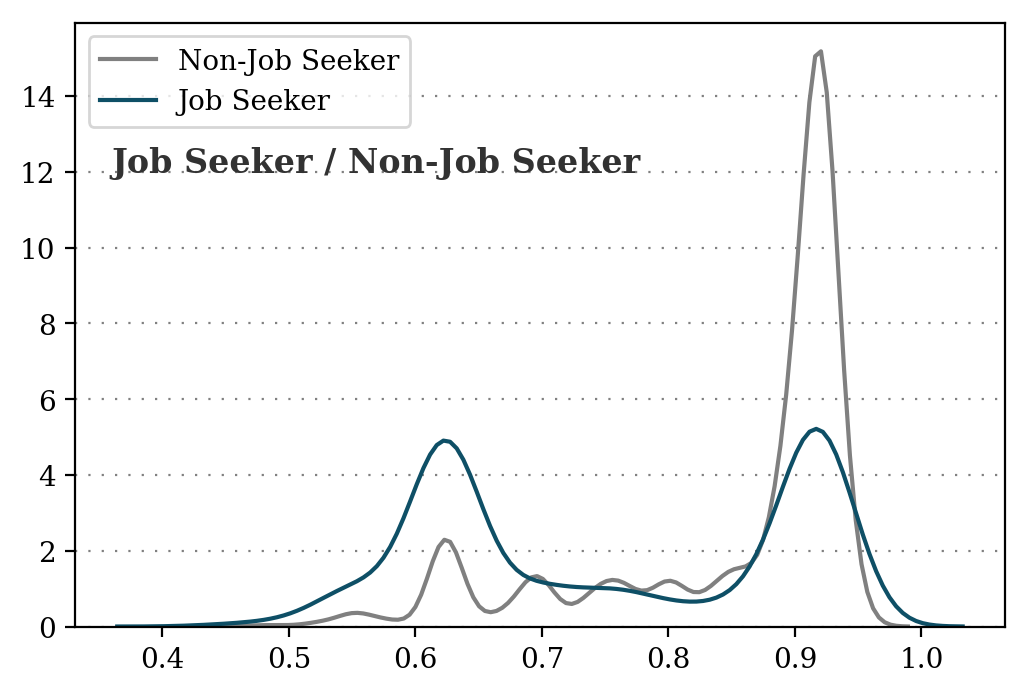

In [207]:
fig, ax = plt.subplots()
ax.text(0.36, 12, 'Job Seeker / Non-Job Seeker', fontsize=12, fontweight='bold', fontfamily='serif', color="#323232")
ax.grid(color='gray', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.kdeplot(train.loc[(train["target"]==0), "city_development_index"], color="gray", label="Non-Job Seeker", ax=ax)
sns.kdeplot(train.loc[(train["target"]==1), "city_development_index"], color="#0e4f66", label="Job Seeker", ax=ax)
ax.set_xlabel("")
ax.set_ylabel("")

In [222]:
###
ed_order = ['Primary School','High School','Graduate','Masters','Phd']
job_order = ['Never', '1', '2', '3', '4', '>4']
train['count'] = 1
job_hunt_only = train[train['target']==1]
no_job_hunt_only = train[train['target']==0]

job_change = train.groupby(['education_level','last_new_job'])['experience'].sum().unstack()

job_hunt_only.groupby(['target','last_new_job'])['count'].sum().unstack()
notseek_job_change = no_job_hunt_only.groupby(['target','last_new_job'])['count'].sum().unstack().T
seek_job_change = job_hunt_only.groupby(['target','last_new_job'])['count'].sum().unstack().T

notseek_job_change.columns = ['count']
seek_job_change.columns = ['count']

notseek_job_change["percentage"] = notseek_job_change["count"].apply(lambda x: x/sum(notseek_job_change["count"])) *100
seek_job_change["percentage"] = seek_job_change["count"].apply(lambda x: x/sum(seek_job_change["count"])) *100




ed_notseek_job_change = no_job_hunt_only.groupby(['target','education_level'])['count'].sum().unstack().T
ed_seek_job_change = job_hunt_only.groupby(['target','education_level'])['count'].sum().unstack().T

ed_notseek_job_change.columns = ['count']
ed_seek_job_change.columns = ['count']

ed_notseek_job_change["percentage"] = ed_notseek_job_change["count"].apply(lambda x: x/sum(ed_notseek_job_change["count"])) *100
ed_seek_job_change["percentage"] = ed_seek_job_change["count"].apply(lambda x: x/sum(ed_seek_job_change["count"])) *100



In [225]:
#seek_job_change = seek_job_change.loc[job_order]
#notseek_job_change = notseek_job_change.loc[job_order]
ed_seek_job_change = ed_seek_job_change.loc[ed_order]
ed_notseek_job_change = ed_notseek_job_change.loc[ed_order]


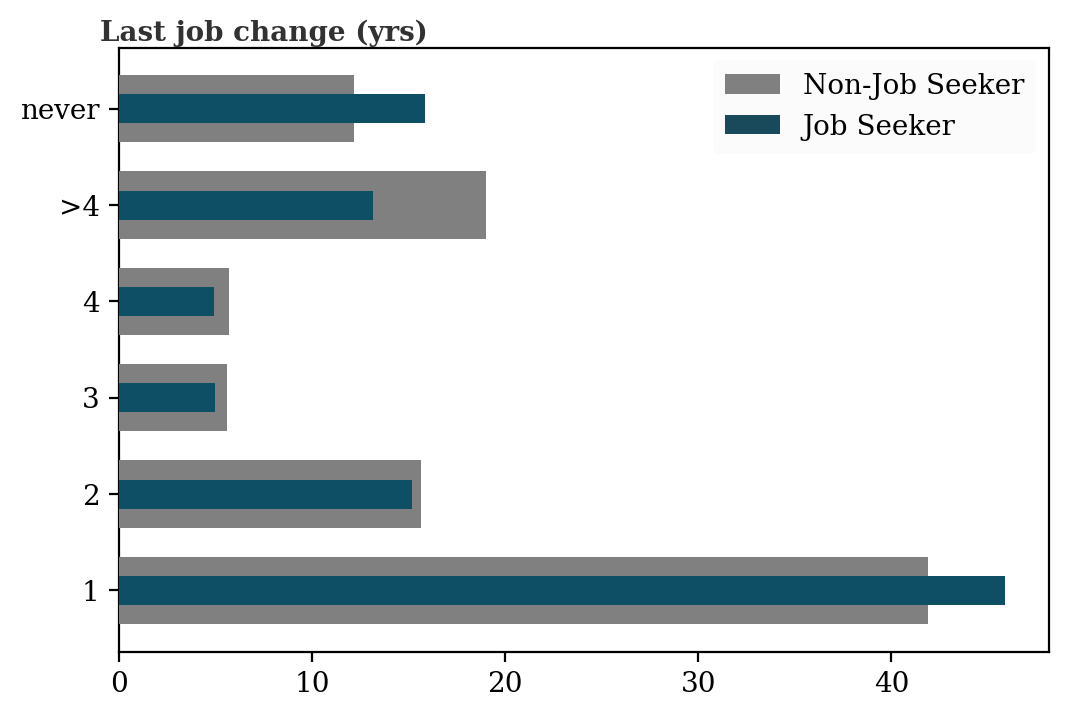

In [240]:
fig, ax = plt.subplots()
ax.barh(notseek_job_change.index, notseek_job_change['percentage'], color="gray", zorder=3, height=0.7)
ax.barh(seek_job_change.index, seek_job_change['percentage'], color="#0e4f66", zorder=3, height=0.3)
ax.xaxis.set_major_locator(mtick.MultipleLocator(10))
ax.text(-1, 5.7, 'Last job change (yrs)',fontsize=10, fontweight='bold', fontfamily='serif',color='#323232')
ax.legend(legend_labels, ["Non-Job Seeker", "Job Seeker"], ncol=1, bbox_to_anchor=(1, 1), 
           facecolor='#fbfbfb', edgecolor='#fbfbfb')

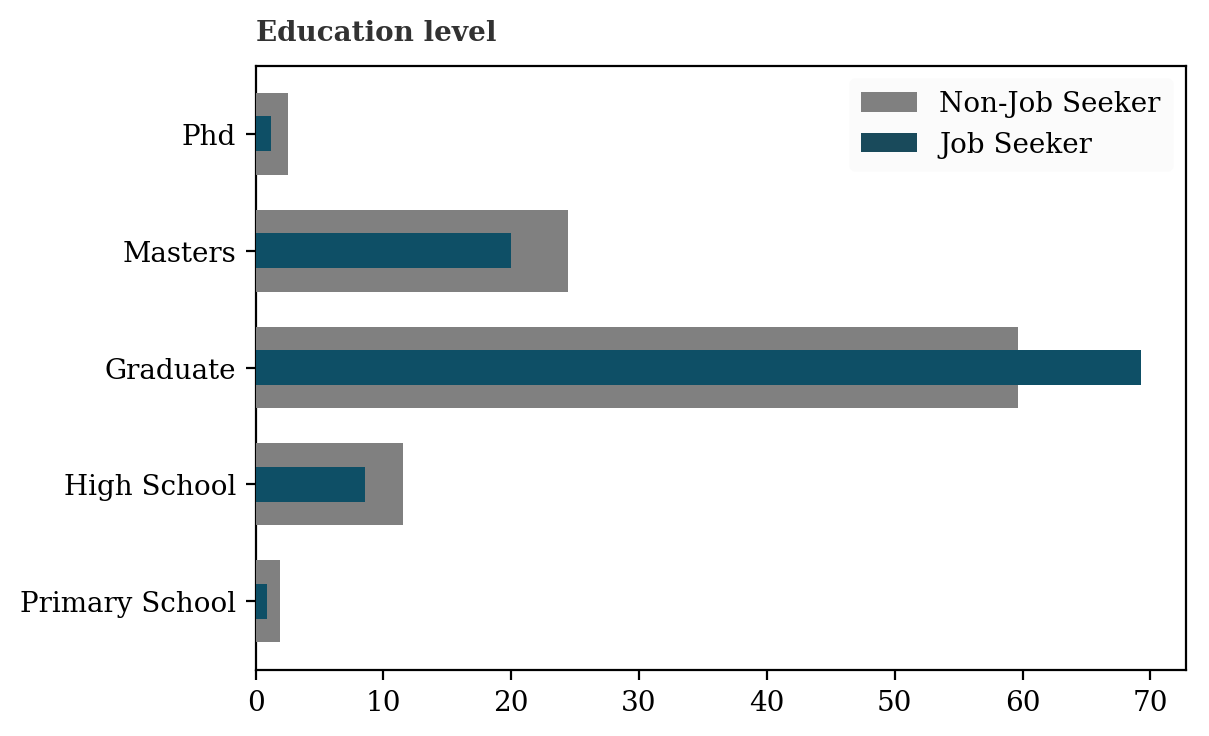

In [241]:
fig, ax = plt.subplots()
ax.barh(ed_notseek_job_change.index, ed_notseek_job_change['percentage'], color="gray", zorder=3, height=0.7)
ax.barh(ed_seek_job_change.index, ed_seek_job_change['percentage'], color="#0e4f66", zorder=3, height=0.3)
ax.xaxis.set_major_locator(mtick.MultipleLocator(10))
ax.text(0, 4.8, 'Education level', fontsize=10, fontweight='bold', fontfamily='serif',color='#323232')
ax.legend(legend_labels, ["Non-Job Seeker", "Job Seeker"], ncol=1, bbox_to_anchor=(1, 1), 
           facecolor='#fbfbfb', edgecolor='#fbfbfb')

## Findings
1. the peak job seekers are in low CDI and high CDI groups
2. job seekers are more likely change job more oftern than non-job seekers
3. more job seekers in the graduate sample than non-job seekers

# predicting

In [ ]:
#TBD